## DO NOT RUN THIS

In [ ]:

import os

aggregate_file = ''

directory = 'C:\\Users\\Collin\\Downloads\\0DN'

aggregate_file = ''
verbose = False
for subdir, dirs, files in os.walk(directory):
    for file in files:
        filepath = os.path.join(subdir, file)
        if verbose: print(f'Reading file: {filepath}')
        with open(filepath, mode='r', encoding='utf-8') as f:
            aggregate_file += '\n' + f.read()
            
dummy_var_agg_file = aggregate_file.replace("\n", "~ ")

with open(os.path.join(directory, 'test.txt'), mode='w', encoding='utf-8') as f:
    f.write(dummy_var_agg_file)

# Start running here

In [1]:
import re
import pickle
import numpy as np
from collections import defaultdict


class Utils(object):
    def build_char_2_id_dict(self, data_set_char, min_freq):
        char_freq = defaultdict(int)
        char_2_id_table = {}

        for char in [char for label, seq in data_set_char for char in seq]:
            char_freq[char] += 1

        id_counter = 1

        for k, v in [(k, v) for k, v in char_freq.items() if v >= min_freq]:
            char_2_id_table[k] = id_counter
            id_counter += 1

        return char_2_id_table

    def build_data_set(self, data_set_char, char_2_id_dict, window_size):

        data_set = []

        for label, char_sequence in data_set_char:
            ids = []

            if len(char_sequence) == 2 * window_size + 1:
                for char in char_sequence:
                    if char in char_2_id_dict:
                        ids.append(char_2_id_dict[char])
                    else:
                        ids.append(0)

                feature_vector = np.array([float(ids[i])
                                           for i in range(0, len(ids))], dtype=float)

                data_set.append((float(label), feature_vector))

        return data_set

    def build_data_set_char(self, t, window_size):
        data_set_char_eos = \
            [(1.0, t[m.start() - window_size:m.start()].replace("\n", " ") +
              t[m.start():m.start() + window_size + 1].replace("\n", " "))
             for m in re.finditer('[\.:?!;~][^\n]?[\n]', t)]

        data_set_char_neos = \
            [(0.0, t[m.start() - window_size:m.start()].replace("\n", " ") +
              t[m.start():m.start() + window_size + 1].replace("\n", " "))
             for m in re.finditer('[\.:?!;~][^\s]?[ ]+', t)]

        return data_set_char_eos + data_set_char_neos

    def build_potential_eos_list(self, t, window_size):
        PUNCT = '[\(\)\u0093\u0094`“”\"›〈⟨〈<‹»«‘’–\'``'']*'
        EOS = '([\.:?!;~])'

        eos_positions = [(m.start())
                         for m in re.finditer(r'([\.:?!;~])(\s+' + PUNCT + '|' +
                                              PUNCT + '\s+|[\s\n]+)', t)]
        potential_eos_position = []

        for eos_position in eos_positions:
            left_context = t[eos_position - (2 * window_size):eos_position]
            right_context = t[eos_position:eos_position + (3 * window_size)]

            cleaned_left_context = left_context
            cleaned_right_context = right_context

            cleaned_left_context = re.sub('\s+', ' ', cleaned_left_context)
            cleaned_right_context = re.sub('\s+', ' ', cleaned_right_context)

            potential_eos_position.append((eos_position,
                                          cleaned_left_context[-window_size:] + t[eos_position] +
                                          cleaned_right_context[1:window_size + 1]))

        return potential_eos_position




In [2]:
import keras
import re

import numpy as np

from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import LSTM, GRU, Bidirectional
from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.layers.noise import AlphaDropout
from keras.callbacks import ModelCheckpoint

from keras.layers.advanced_activations import LeakyReLU





Using TensorFlow backend.


In [3]:
training_file='data/combined.txt'
window_size=6
epochs=5
batch_size=32
dropout=0.25
min_freq=10000
max_features=20000
embedding_size=128
lstm_gru_size=256
mlp_dense=6
mlp_dense_units=16
kernel_size=5
filters=64
pool_size=2
hidden_dims=250
strides=1
model_filename='best_model.hdf5'
vocab_filename='vocab.dump'


In [4]:

util = Utils()
with open(training_file, mode='r', encoding='utf-8') as f:
    training_corpus = f.read()

data_set_char = util.build_data_set_char(
    training_corpus, window_size)
char_2_id_dict = util.build_char_2_id_dict(
    data_set_char, min_freq)

data_set = util.build_data_set(data_set_char, char_2_id_dict,
                                    window_size)

x_train = np.array([i[1] for i in data_set])
y_train = np.array([i[0] for i in data_set])

maxlen = 2 * window_size + 1

model = Sequential()



model.add(Embedding(max_features,
                    embedding_size))

model.add(
    LSTM(
        lstm_gru_size,
        dropout=dropout,
        recurrent_dropout=dropout))

model.add(Dense(1, activation='sigmoid'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [5]:
model.load_weights('best_model.hdf5')

In [6]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               394240    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 2,954,497
Trainable params: 2,954,497
Non-trainable params: 0
_________________________________________________________________


In [8]:
model.fit(x_train, y_train, epochs=10, batch_size=batch_size)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
8436/8436 [==============================] - 7s 883us/step - loss: 0.7105 - acc: 0.5615
Epoch 2/10
8436/8436 [==============================] - 6s 705us/step - loss: 0.6569 - acc: 0.6126
Epoch 3/10
8436/8436 [==============================] - 6s 708us/step - loss: 0.6429 - acc: 0.6208
Epoch 4/10
8436/8436 [==============================] - 6s 701us/step - loss: 0.6242 - acc: 0.6376
Epoch 5/10
8436/8436 [==============================] - 6s 697us/step - loss: 0.6160 - acc: 0.6382
Epoch 6/10
8436/8436 [==============================] - 6s 701us/step - loss: 0.6012 - acc: 0.6482
Epoch 7/10
8436/8436 [==============================] - 6s 699us/step - loss: 0.5952 - acc: 0.6501
Epoch 8/10
8436/8436 [==============================] - 6s 702us/step - loss: 0.5927 - acc: 0.6532
Epoch 9/10
8436/8436 [==============================] - 6s 707us/step - loss: 0.5865 - acc: 0.6581
Epoch 10/10
8436/8436 [==============================] - 6s 7

In [9]:
model_json = model.to_json()
with open("sentence_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("sentence_model.h5")
print("Saved model to disk")

Saved model to disk


In [11]:
with open('data/test.txt', mode='r', encoding='utf-8') as f:
    t = f.read()

t = t[-50000:]
eos_marker="</eos>"
    
potential_eos_list = util.build_potential_eos_list(t, window_size)

eos_counter = 0

for potential_eos in potential_eos_list:
    start, char_sequence = potential_eos

    data_set = util.build_data_set([(-1.0, char_sequence)],
                                        char_2_id_dict,
                                        window_size)

    if len(data_set) > 0:
        label, feature_vector = data_set[0]

        predicted = model.predict(
            feature_vector.reshape(
                1,
                2 * window_size + 1),
            batch_size=batch_size,
            verbose=0)

        if predicted[0][0] >= .5:
            t = t[:(eos_counter * len(eos_marker)) + start + 1] + \
                eos_marker + t[(eos_counter * len(eos_marker)) + start + 1:]
            eos_counter += 1

blocked_text = t[:] + eos_marker
sent_list = blocked_text.split('</eos>')

In [12]:
lens = []
for sent in blocked_text.split('</eos'):
    lens.append(len(sent))
    
print(np.mean(lens))

79.00156006240249


In [158]:
import matplotlib.pyplot as plt

(array([103.,  24.,  14.,   6.,   3.,   1.,   1.,   0.,   0.,   2.]),
 array([1.0000e+00, 3.1660e+02, 6.3220e+02, 9.4780e+02, 1.2634e+03,
        1.5790e+03, 1.8946e+03, 2.2102e+03, 2.5258e+03, 2.8414e+03,
        3.1570e+03]),
 <a list of 10 Patch objects>)

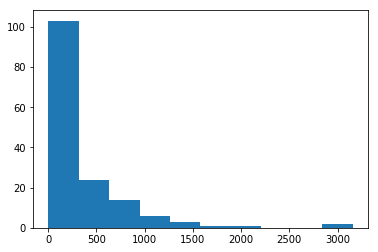

In [159]:
plt.hist(lens)

In [140]:
np.array(lens)

array([ 602,  153,   41,   27,    3,   17,    3,    3,  140,    3,  695,
        645,   47,  224,   34,  103,  186,   24,   19,   61,   85,   74,
         27,  196,   47,  236,  128,  284,   67,  441,  445,  452,   48,
        131,  191,   15,   85,  127,   15,  257,   11,  211,  285,    3,
        326,  761,   23,   13,   27,    3,   17,    3,    3,  141,    3,
        374,   89,   24,   77,  165,  238,  248,   72,  115,   24,   83,
         38,  135,   52,  102,  162,   11,   26,  138,   39,  471,   71,
         68,   42,  414,  112,  405,   29,   53,  446,   87,   85,  127,
         32,  146,  438,  405,   39,   64,   57,  124,  283,  114,   83,
         73,  106,   75,  161,  145,    3,   17,    3,    3,  146,    3,
        126,  407,  434,   18,   24,   20,   17,   32,   94,  158,  165,
         49,   34,  214,  125, 1095,    9,  167,   11,   26,  149,  127,
         80,  213,  351,   29,   74,  104,  330,  308,  149,  545,   39,
        323,  143,  329,   10,   86,  100,  637,   

In [160]:

for sent in blocked_text.split('</eos'):
    print(sent)
    print('\n\n\n')

eatment times five days was recommended by urology. She had a~ follow-up plastic surgery appointment scheduled for the following~ day after discharge. Her hyponatremia of 115 resolved with~ hydration with normal saline. Patient was discharged with normal~ liver function tests and normal amylase and lipase. Serum sodium~ had returned to baseline.~ DISPOSITION: She is discharged in stable condition.~ DISCHARGE MEDICATIONS: Vasotec 10 mg p.o. q.d. , NPH insulin 30~ units subcutaneously q.a.m. , NPH insulin 10~ units subcutaneously q.p.m. , Cisapride 10 mg p.o. q.i.d. , ofloxacin~ 200 mg p.o. b.i.d. times four days , and Colace 100 mg p.o. b.i.d.~ Dictated By: SAL D. PAPIERNIK , M.D. VJ46~ Attending: VITO J. SHEMWELL , M.D. MZ26~ VY391/2804~ Batch: 56247 Index No. BDAM4R9RO2 D: 10/14/97~




> T: 3/18/97~ [report_end]~




> ~




> RECORD #889300~




> ~




> ~




> 140853840 | TCH | 33840061 | | 6176516 | 1/3/2004 12:00:00 AM | PNEUMONIA | Signed | DIS | Admission Date: 1/3/2004 Repor